# Oseen Wake

This notebook deals with the Oseen wake that is responsible for the lifting force and back flipping of air bubbles. The flow field can be expressed in spherical coordinates as follows:

$$
\frac{u_r}{U} = -\frac{a^3 \cos \theta}{2r^3} + \frac{3a^2}{2r^2 Re} \left\{ 1 - \exp\left[ -\frac{rRe}{2a} (1 + \cos\theta) \right] \right\} \\- \frac{3a(1-\cos\theta)}{4r} \exp\left[ -\frac{rRe}{2a} (1 + \cos\theta) \right] 
$$

$$
\frac{u_\theta}{U} = -\frac{a^3\sin\theta}{4r^3} - \frac{3a\sin\theta}{4r}\exp\left[ -\frac{rRe}{2a} (1+\cos\theta) \right]
$$

$$
\frac{u_\varphi}{U} = 0
$$

Since the bubble simulation is formulated in Cartesian coordinates, we convert the above to $u_x$, $u_y$ and $u_z$ using:

$$
u_x = u_r \sin\theta\cos\phi + u_\theta \cos\theta\cos\phi - u_\phi\sin\phi
$$

$$
u_y = u_r \sin\theta\sin\phi + u_\theta \cos\theta\sin\phi + u_\phi\cos\phi
$$

$$
u_z = u_r \cos\theta - u_\theta\sin\theta
$$

where 

$$
\sin\theta = \frac{\sqrt{x^2 + y^2}}{r}
$$

$$
\cos\theta = \frac{z}{r}
$$

$$
\sin\phi = \frac{y}{\sqrt{x^2 + y^2}}
$$

$$
\cos\phi = \frac{x}{\sqrt{x^2 + y^2}}
$$

and 

$$
r = \sqrt{x^2 + y^2 + z^2}
$$

## 0 Packages

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import healpy as hp
pv.set_jupyter_backend("trame")
from bubble_bouncing.bubble import Bubble, Vector

ImportError: cannot import name 'Vector' from 'bubble_bouncing.bubble' (/Users/zhengyang/Documents/GitHub/bubble_bouncing/bubble_bouncing/bubble/__init__.py)

## 1 Velocity field in Cartesian coordinates

### 1.1 Put the equations in code

In [32]:
# define constants
U = 1.0e-4
mu = 1.0e-3
rho = 1.0e3
a = .3
Re = rho * a * U / mu

In [33]:
# define mesh
lim = 3*a
res = 10
x = np.linspace(-lim, lim, res)
y = np.linspace(-lim, lim, res)
z = np.linspace(-lim, lim, res)
x, y, z = np.meshgrid(x, y, z)

x = x.flatten()
y = y.flatten()
z = z.flatten()

In [34]:
# compute variables in spherical coordinates
r = (x**2 + y**2 + z**2) ** 0.5
sint = (x**2 + y**2)**0.5 / r
cost = z / r
sinp = y / (x**2 + y**2)**0.5
cosp = x / (x**2 + y**2)**0.5

In [35]:
valid_ind = r > a

In [36]:
# velocity field in spherical coordinates
u_r = U * ( 
    - a**3 * cost / 2 / r**3 
    + 3 * a**2 / (2 * r**2 * Re) * (
        1 - np.exp(- r * Re / 2 / a * (1 + cost))
    )
    - 3 * a * (1 - cost) / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
)
u_t = U * (
    - a**3 * sint / 4 / r**3 
    - 3 * a * sint / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
)
u_p = 0

In [37]:
# convert spherical coordinates velocity to Cartesian
# up to here, we have u(x, y, z) 
u_x = u_r * sint * cosp + u_t * cost * cosp - u_p * sinp
u_y = u_r * sint * sinp + u_t * cost * sinp + u_p * cosp
u_z = u_r * cost - u_t * sint

In [38]:
for i in [x, y, z, u_x, u_y, u_z]:
    i[~valid_ind] = np.nan

In [39]:
points = np.stack([x, y, z], axis=-1)
velocity = np.stack([u_x, u_y, u_z], axis=-1)
ones = np.ones(velocity.shape[0])

pl = pv.Plotter()
grid = pv.PolyData(points)
grid["v"] = velocity
grid["v_mag"] = np.linalg.norm(velocity, axis=1)
grid["ones"] = ones
# pl.add_mesh(grid)
glyphs = grid.glyph(orient="v", scale="v", factor=10000)
pl.add_mesh(glyphs)
pl.show_axes()
pl.camera_position = "xz" 
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

### 1.2 Implement a `Sphere` class for the ease of use

We consider the bubbles as a sphere object, which is defined by a radius `a` and a position `pos`. If moving at a velocity `U`, it generates a Oseen wake that induces lift on another sphere. In this sense, the Oseen wake is a property associated with the moving sphere. Also, the surface locations are also properties of a sphere. To structure the code in a more efficient and convenient way, we construct a `Sphere` class, where these properties are computed internally based on the radius and position. 

In [40]:
class Sphere:
    """Compute the flow field in a Oseen wake. The flow field is characterized by two regions: a Stokeslet in the low Reynolds region and a compensating flow """
    def __init__(self, a, U=0, rho=1e3, mu=1e-3):
        self.a = a # bubble radius
        self.U = U # upward velocity (only upward!)
        self.rho = rho # density
        self.mu = mu # viscosity
        self.pos = np.array([0, 0, 0]) # bubble position
        self.surf_coords, self.unit_normals, self.ds = self._compute_surface_coords()
        self.unit_tangents = self._compute_surface_tangent_xz()

    def Oseen_wake(self, points):
        """Compute Oseen wake at given points. 

        Args:
        points -- should be an array of (npts, 3), the points to evaluate Oseen wake flow field.

        Returns: 
        flow -- the flow velocity at each given point, also (npts, 3).
        """
        U = self.U
        a = self.a
        rho = self.rho
        mu = self.mu
        Re = rho * a * U / mu

        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        r = (x**2 + y**2 + z**2) ** 0.5
        sint = (x**2 + y**2)**0.5 / r
        cost = z / r
        sinp = y / (x**2 + y**2)**0.5
        cosp = x / (x**2 + y**2)**0.5

        u_r = U * ( 
            - a**3 * cost / 2 / r**3 
            + 3 * a**2 / (2 * r**2 * Re) * (
                1 - np.exp(- r * Re / 2 / a * (1 + cost))
            )
            - 3 * a * (1 - cost) / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
        )
        u_t = U * (
            - a**3 * sint / 4 / r**3 
            - 3 * a * sint / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
        )
        u_p = 0

        u_x = u_r * sint * cosp + u_t * cost * cosp - u_p * sinp
        u_y = u_r * sint * sinp + u_t * cost * sinp + u_p * cosp
        u_z = u_r * cost - u_t * sint

        # The velocity diverges at r=0, implying that this velocity should be considered as "far field" velocity
        # thus, we mask out all the velocities inside the imaginary shpere, where r <= a
        invalid = r <= a
        u_x[invalid] = 0
        u_y[invalid] = 0
        u_z[invalid] = 0

        return np.stack([u_x, u_y, u_z], axis=-1)
    
    def get_pos(self):
        return self.pos
    
    def set_pos(self, pos):
        self.pos = np.array(pos)

    def _compute_surface_coords(self, nside=4):
        """Compute the coordinates of the surface differential area and surface unit normal vectors.
        
        Args:
        nside -- controls how many parts the spherical surface is to be divided, utilizing the `healpy` package. Has to be power of 2. The number of parts will be 12*nside**2.
        
        Returns:
        surface_coords -- coordinates of surface differential area __relative to the center__ of the sphere.
        unit_normals -- unit normal vectors corresponding to the surface locations.
        differential_surface_area -- the area of each differential surface unit."""

        R = self.a
        npix = hp.nside2npix(nside)

        # Get spherical coordinates (theta, phi) of each pixel center
        theta, phi = hp.pix2ang(nside, np.arange(npix))

        x = R * np.sin(theta) * np.cos(phi) 
        y = R * np.sin(theta) * np.sin(phi) 
        z = R * np.cos(theta)
        surface_coords = np.stack([x, y, z], axis=-1)
        unit_normals = surface_coords / np.linalg.norm(surface_coords, axis=-1, keepdims=True)
        differential_surface_area = 4 * np.pi * R**2 / npix
        return surface_coords, unit_normals, differential_surface_area
    
    def _compute_surface_tangent_xz(self):
        """Compute sphere surface tangential unit vectors, specifically their projections on the xz plane."""
        tangent = np.zeros_like(self.unit_normals)
        tangent[:, 0] = self.unit_normals[:, 2]
        tangent[:, 2] = - self.unit_normals[:, 0]
        return tangent / np.linalg.norm(tangent, axis=1, keepdims=True)

In [41]:
U = 1.0e-4
a = .2
im = Sphere(a, U=U) # the imaginary bubble instance
re = Sphere(a) # the real bubble instance
re.set_pos([.5, 0, -.5]) # set real bubble to be away from the imaginary bubble

In [42]:
# check the surface coordinates calculation
grid = pv.PolyData(re.surf_coords)
pl = pv.Plotter(window_size=(400, 400))
grid["normal"] = re.unit_normals
glyph = grid.glyph(orient="normal", scale="normal", factor=.05)
pl.add_mesh(grid)
pl.add_mesh(glyph)
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [43]:
# Check the flow around the bubble
rel_pos = re.surf_coords - re.pos - im.pos # calculated the relative position between the surface of real sphere and the center of the imaginary sphere
flow = im.Oseen_wake(rel_pos)

In [44]:
# do multiple spheres around a imaginary sphere that generates Oseen Wake
locs = [(0, 0, -0.5), (0.5, 0, -0.5), (1, 0, -0.5),
        (0, 0, -1  ), (0.5, 0, -1.0), (1, 0, -1),
        (0.5, 0, 0) , (1.0, 0, 0)]
spheres = []
for loc in locs:
    s = Sphere(a)
    s.set_pos(loc)
    spheres.append(s)

In [45]:
# direction of the flow
pl = pv.Plotter()
mesh = pv.Sphere(radius=im.a, center=im.pos)
pl.add_mesh(mesh, opacity=0.3)
for re in spheres:
    rel_pos = re.surf_coords + re.pos - im.pos
    flow = im.Oseen_wake(rel_pos)
    grid = pv.PolyData(re.pos + re.surf_coords)
    mesh = pv.Sphere(radius=re.a, center=re.pos)
    grid["flow"] = flow
    grid["normal"] = np.linalg.norm(re.unit_normals, axis=1)
    glyph = grid.glyph(orient="flow", scale="normal", factor=.1)
    pl.add_mesh(mesh)
    pl.add_mesh(glyph)
pl.add_axes()
pl.camera_position = "xz"
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [48]:
pl = pv.Plotter()
mesh = pv.Sphere(radius=im.a, center=im.pos)
pl.add_mesh(mesh, opacity=0.3)
for re in spheres:
    rel_pos = re.surf_coords + re.pos - im.pos
    flow = im.Oseen_wake(rel_pos)
    # clip the velocity data
    max_mag = 0.001
    # Normalize and rescale any vector > max_mag
    mag = np.linalg.norm(flow, axis=1)
    scale = np.minimum(1.0, max_mag / (mag + 1e-12))  # Avoid divide-by-zero
    flow_clipped = flow * scale[:, np.newaxis]
    grid = pv.PolyData(re.pos + re.surf_coords)
    mesh = pv.Sphere(radius=re.a, center=re.pos)
    grid["flow"] = flow_clipped
    grid["normal"] = np.linalg.norm(re.unit_normals, axis=1)
    glyph = grid.glyph(orient="flow", scale="flow", factor=20000)
    pl.add_mesh(mesh)
    pl.add_mesh(glyph)
pl.add_axes()
pl.camera_position = "xz"
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## 2 Velocity on a spherical shell

In the simulation, we want to compute the velocity (i.e. the shear force) acting on the whole bubble surface and integrate the effect. In this section, we implement this calculation by

1. Identifying surface locations and normals (done in Sphere class);
2. Getting flow field at each location (done in Sphere class);
3. Computing tangential projections;
4. Integrating over the surface.

We consider two bubbles, one imaginary and one real, as sketched below. The imaginary bubble generates and Oseen wake, which drives the rotation and translation of the real bubble. 

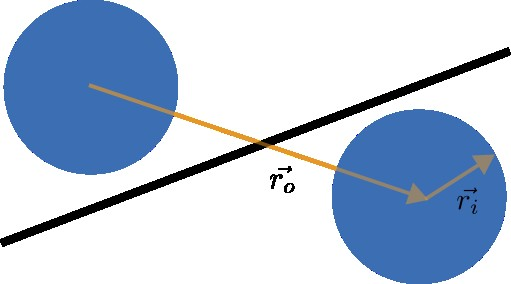

We calculate the average circulation $\bar\Gamma$ as

$$
\bar\Gamma = \frac{1}{2a} \int_S u_s \; dS,
$$

where $a$ is the radius of bubble and $u_s$ is the projection of velocity on the spherical surface. Furthermore, since we only consider vorticity in the $xz$ plane, we also project the velocity in the $xz$ plane. 

Then, we calculate an approximated local vorticity as

$$
\bar\omega \approx \frac{1}{\pi a^2} \bar\Gamma.
$$

The lift force $F_l$ points to the left if the circulation is CW, and has the form

$$
F_l = C_l \mathbf{\bar\omega} \times \mathbf{U} 
$$

where $C_l$ is the lift coefficient, and $\mathbf{U}$ is the velocity of the bubble. 

$$
F_l =  \frac{C_l}{\pi a^2} \bar\Gamma \times \mathbf{U}
$$

### 2.1 Compute unit tangents

In [19]:
U = 1.0e-4
a = .2
im = Sphere(a, U=U) # the imaginary bubble instance
re = Sphere(a) # the real bubble instance
re.set_pos([.3, 0, -.5]) # set real bubble to be away from the imaginary bubble

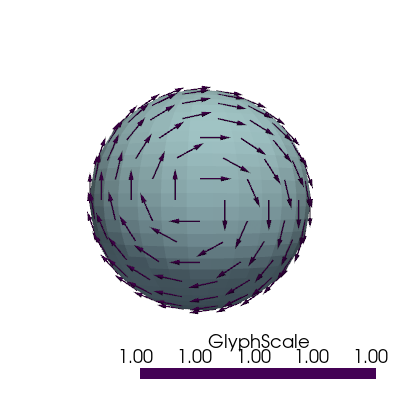

In [20]:
grid = pv.PolyData(re.surf_coords)
mesh = pv.Sphere(radius=re.a)
pl = pv.Plotter(window_size=(400, 400))
grid["tangents"] = re.unit_tangents
glyph = grid.glyph(orient="tangents", scale="tangents", factor=.05)
pl.add_mesh(mesh)
pl.add_mesh(glyph)
pl.camera_position = "xz"
pl.show()

### 2.2 Compute the integration of the tangential projection

In [21]:
rel_pos = re.surf_coords + re.pos - im.pos
flow = im.Oseen_wake(rel_pos)
flow_surf_xz = (flow * re.unit_tangents).sum(axis=1)

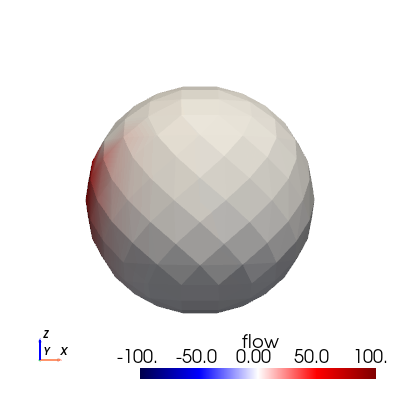

In [22]:
grid = pv.PolyData(re.surf_coords)
mesh = grid.delaunay_3d()
pl = pv.Plotter(window_size=(400, 400))
mesh["flow"] = flow_surf_xz
pl.add_mesh(mesh, scalars="flow", clim=[-100, 100], cmap="seismic")
pl.camera_position = "xz"
pl.show_axes()
pl.show()

### 2.3 Compute lift force

$$
F_l =  \frac{C_l}{\pi a^2} \bar\Gamma \times \mathbf{U}
$$

where $a$ is the bubble radius, $\bar\Gamma$ is the mean circulation and $\mathbf{U}$ is the velocity of the bubble. 

The circulation $\Gamma$ has the unit of length^2/time.

In [ ]:
def compute_lift(a, surface_flow, ds, U, lift_coef=1.0):
    """Compute the circulation induced by the Oseen wake flow. We use the following formula
    
    Gamma = 1/2a \int_S u_s dS
    lift = 4 * np.pi * a**3 / 3 * lift_coef / np.pi / a**2 * (Gamma x U)

    Parameters
    ----------
    a : float
        bubble radius
    surface_flow : ndarray[float]
        flow field projection on the intersection between bubble surface and xy plane
    ds : float
        differential area on the bubble surface
    U : float
        bubble velocity
    lift_coef : float
        lift coefficient
    
    Return
    ------
    lift : float
        lift force

    Note
    ----
    The definition of surface tangents in the Bubble class dictates that positive Gamma represents CW rotation, where the direction of vorticity points in +z. Therefore, the vector form Gamma should be the magnitude times e_z. 

    Example
    -------
    >>> flow = im.Oseen_wake(re.surf_coords+re.pos)
    >>> surface_flow = flow * re.unit_tangents
    >>> lift = compute_lift(a, surface_flow, re.ds, re.U)
    """
    
    Gamma = 1 / 2 / a * surface_flow.sum() * ds * np.array([0, 0, 1])
    lift = 4 * np.pi * a**3 / 3 * lift_coef / np.pi / a**2 * np.cross(Gamma, U)
    return lift

In [16]:
a = 6e-4
theta = 22.5 / 180 * np.pi
U_im = 3e-1 * np.array([np.sin(theta), -np.cos(theta), 0])
U_re = 3e-1 * np.array([np.sin(theta), np.cos(theta), 0])
im = Bubble(a, U=U_im) # the imaginary bubble instance
re = Bubble(a, U=U_re) # the real bubble instance
re.set_pos([a, -a, 0]) # set real bubble to be away from the imaginary bubble

In [17]:
flow = im.Oseen_wake(re.surf_coords+re.pos)
surface_flow = flow * re.unit_tangents
lift = compute_lift(a, surface_flow, re.ds, re.U)

In [19]:
lift

array([ 2.19340081e-09, -9.08536364e-10,  0.00000000e+00])

## 3 Oseen wake of an off-axis velocity

In the original formulation, the flow velocity is fixed in $\theta=0$ direction. This is general because of the rotational symmetry of the spherical coordinates. However, when convert to Cartesian coordinates, we need to consider the velocity of bubble in any directions, i.e., $U$ should be a vector.

### 3.1 Original flow assuming velocity in $z$

In [2]:
# define bubble and tilted surface
a = 6e-4
theta = np.pi / 8 # tilted angle
U = 0.1 * np.array([np.sin(theta), -np.cos(theta), 0])

In [5]:
# construct the grid
lim = 3*a
N = 10
bubble = Bubble(a, np.linalg.norm(U))
points = bubble._grid()
points = Vector(points)

In [6]:
# compute the raw Oseen wake flow, assuming z velocity
flow = Vector(bubble.Oseen_wake(points))

In [7]:
grid = pv.PolyData(points)
grid["v"] = flow
glyph = grid.glyph(orient="v", scale="v", factor=0.02)
pl = pv.Plotter()
pl.show_axes()
pl.add_mesh(glyph)
pl.show()

Widget(value='<iframe src="http://localhost:64685/index.html?ui=P_0x105d4bf10_0&reconnect=auto" class="pyvista…

### 3.2 Determine rotation axis $k$ and angle $\alpha$

In [8]:
zn = np.array([0, 0, 1])
U_unit = U / np.linalg.norm(U)

In [9]:
def _compute_rotation_axis_and_angle(U_unit, zn):
    """Compute the rotation axis and angle to rotate the flow field from z direction to U_unit direction."""
    k = np.cross(zn, U_unit)
    k /= np.linalg.norm(k)
    cos_alpha = np.dot(zn, U_unit)
    alpha = np.arccos(cos_alpha)
    return k, alpha

In [10]:
k, alpha = _compute_rotation_axis_and_angle(U_unit, zn)

In [11]:
points_rotated = points.rotate(k, alpha)
flow_rotated = flow.rotate(k, alpha)

In [12]:
grid = pv.PolyData(points_rotated)
grid["v"] = flow_rotated
bb = pv.Sphere(radius=bubble.a, center=bubble.pos)
glyph = grid.glyph(orient="v", scale="v", factor=0.02)
pl = pv.Plotter()
pl.show_axes()
pl.add_mesh(glyph)
pl.add_mesh(bb, color="orange", opacity=0.5)
pl.camera_position = [(0, 0, -.01),
                      (0, 0, 0 ),
                      U_unit]
pl.show()

Widget(value='<iframe src="http://localhost:64685/index.html?ui=P_0x105769a90_1&reconnect=auto" class="pyvista…

### 3.4 Implement Bubble class that works for arbitrary U direction

In [2]:
# define bubble and tilted surface
a = 6e-4
theta = np.pi / 8 # tilted angle
U = 0.1 * np.array([np.sin(theta), -np.cos(theta), 0])
U_unit = U / np.linalg.norm(U)

In [3]:
im = Bubble(a, U)
im.set_pos([0, -a, 0])
re = Bubble(a, -U)
re.set_pos([5*a, 3*a, 0])

In [4]:
flow = im.Oseen_wake(re.surf_coords + re.pos)

In [5]:
grid = pv.PolyData(re.surf_coords + re.pos)
grid["v"] = flow
im_bb = pv.Sphere(radius=im.a, center=im.pos)
re_bb = pv.Sphere(radius=re.a, center=re.pos)
glyph = grid.glyph(orient="v", scale="v", factor=1)
pl = pv.Plotter()
pl.show_axes()
pl.add_mesh(glyph)
pl.add_mesh(im_bb, color="orange", opacity=0.5, smooth_shading=True
            )
pl.add_mesh(re_bb, color="orange", opacity=1, smooth_shading=True)
pl.camera_position = [(0, 0, -.03),
                      (0, 0, 0 ),
                      U_unit]
pl.show()

Widget(value='<iframe src="http://localhost:52570/index.html?ui=P_0x103fba880_0&reconnect=auto" class="pyvista…

In [6]:
flow_tan = (flow * re.unit_tangents).sum(axis=1, keepdims=True) * re.unit_tangents

In [7]:
grid = pv.PolyData(re.surf_coords + re.pos)
grid["v"] = flow_tan
im_bb = pv.Sphere(radius=im.a, center=im.pos)
re_bb = pv.Sphere(radius=re.a, center=re.pos)
glyph = grid.glyph(orient="v", scale="v", factor=1)
pl = pv.Plotter()
pl.show_axes()
pl.add_mesh(glyph)
pl.add_mesh(im_bb, color="orange", opacity=0.5, smooth_shading=True
            )
pl.add_mesh(re_bb, color="orange", opacity=1, smooth_shading=True)
pl.camera_position = [(0, 0, -.03),
                      (0, 0, 0 ),
                      U_unit]
pl.show()

Widget(value='<iframe src="http://localhost:52570/index.html?ui=P_0x30e0c1820_1&reconnect=auto" class="pyvista…

# Appendix

## A. No overlapping?

In my simulation, the first bounce moment looks like the following, where the imaginary and the real bubble are not overlapping. This is unexpected. Here, I investigate this issue.

![截屏2025-07-16 07.26.13.png](<attachment:截屏2025-07-16 07.26.13.png>)
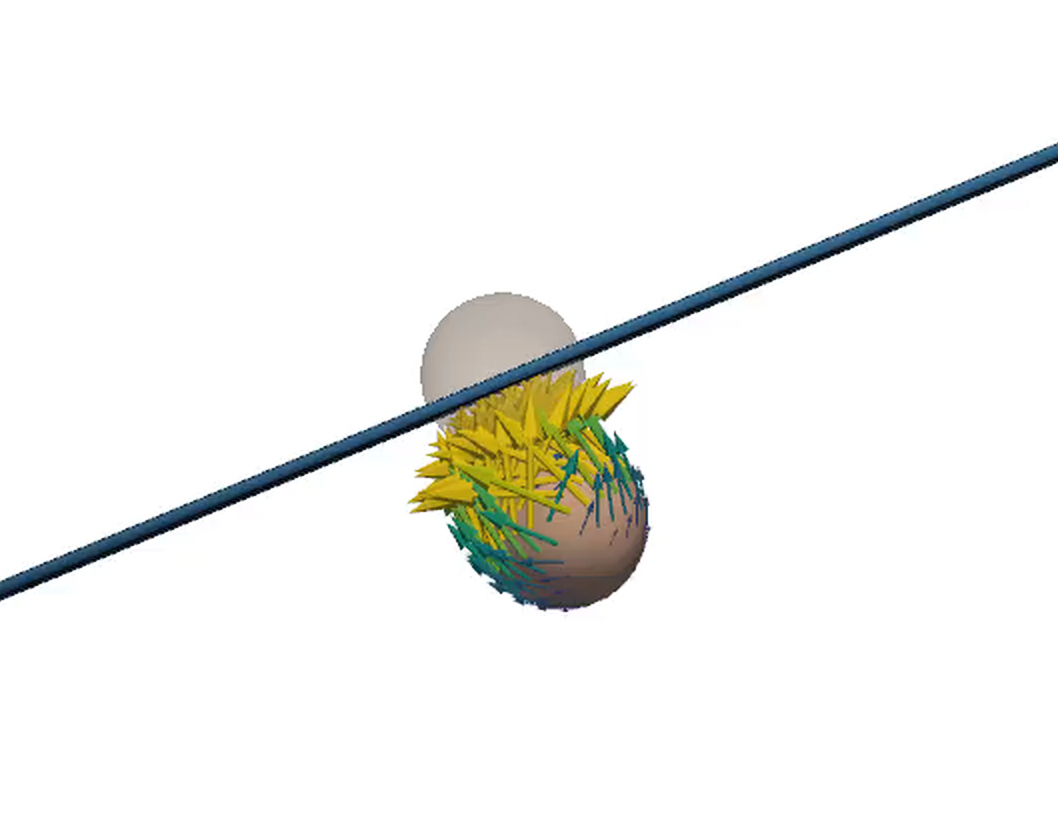

In [22]:
import yaml
from bubble_bouncing import SimulationParams
import h5py
from pathlib import Path
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

In [81]:
folder = "~/Documents/.bcsim_test"
folder = Path(folder).expanduser().resolve()

data = {}
# load data
with h5py.File(folder / "results" / "data.h5", "r") as f:
    for key in f.keys():
        data[key] = f[key][:]

# load params
with open(folder / "params.yaml") as f:
    params_dict = yaml.safe_load(f)
    params = SimulationParams(**params_dict)

### A.1 Plot both traj's

In [82]:
# crop data before tlim
tlim = 0.05
ind = data["t"] < tlim
for key in data:
    data[key] = data[key][ind]

In [83]:
im = data["x_im"]
re = data["x"]
t = data["t"]

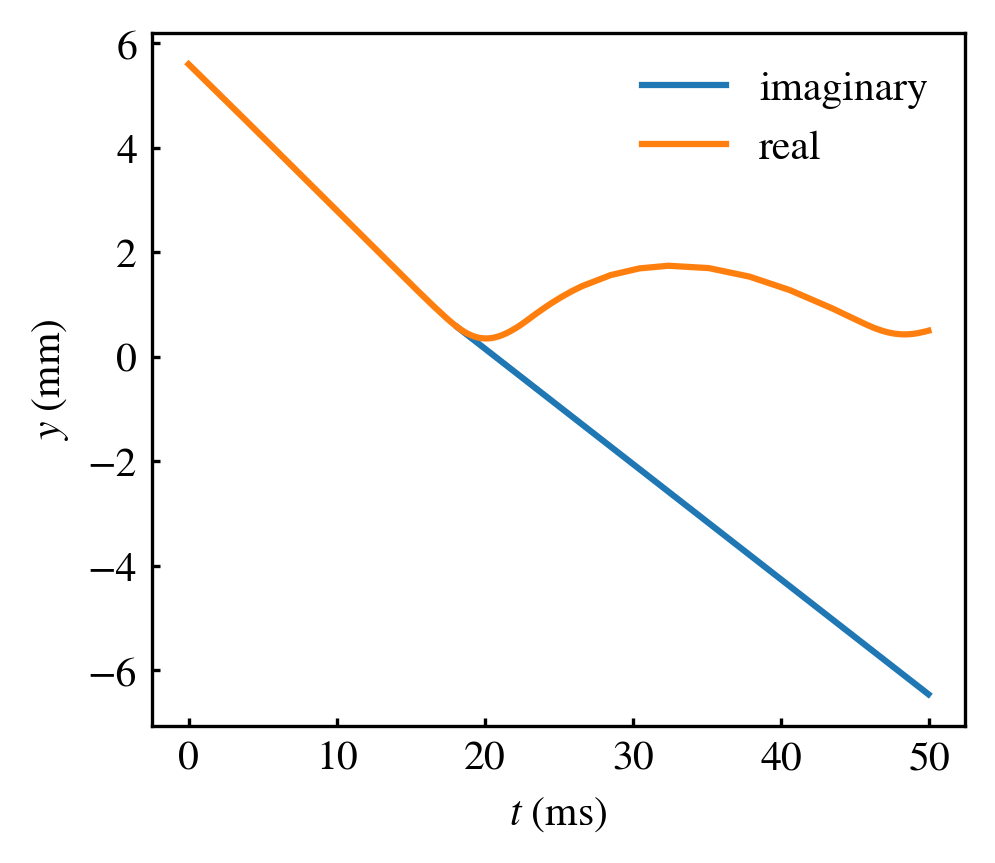

In [84]:
plt.figure(figsize=(3.5, 3), dpi=300)
plt.plot(t*1e3, im[:, 1]*1e3, label="imaginary")
plt.plot(t*1e3, re[:, 1]*1e3, label="real")
plt.xlabel("$t$ (ms)")
plt.ylabel("$y$ (mm)")
plt.legend(frameon=False)

As can be seen, when the imaginary bubble first emerges, it is already at a different y location than the real bubble. This is exactly what we saw in the video visualization, and this confirms that this is a logic issue. 

It turns out that the issue roots in the way I determine the first bounce. I write the condition in the `compute_force` function, which executes even if convergence condition is not met. This leads to erroneous starting point. In the updated code, the first bounce condition is moved to `event_print` function, and the initial bounce is captured correctly.